In [1]:
import pandas as pd
import os
import gzip
import pickle
import openai
import re
import copy
from tqdm import tqdm
from torch import save,load
import time
import json

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('outputs/outputs_chunk_1.csv')

In [3]:
print(df.iloc[3]["output"]) #example: ```json{  "categories": [     "optimistic_speculation","altcoins"

```json
{
  "categories": [ 
    "bitcoin_technology",
    "bitcoin_mining"


In [4]:

all_categories = ["optimistic_speculation", "pessimistic_speculation", "bitcoin_adoption", "bitcoin_technology", "financial_products", "bitcoin_challenges", "scams", "bitcoin_mining", "altcoins", "educational_resources", "other"]

categories = ["optimistic_speculation", "pessimistic_speculation", "bitcoin_adoption", "bitcoin_technology", "bitcoin_challenges", "altcoins", "educational_resources"]

categories = all_categories

months = {}

# for i in range(1, 14):
for (i,file) in enumerate(os.listdir('outputs/')):
    i = i+1
    # print(i)
    df = pd.read_csv('outputs/' + file)
    for row in df.iterrows():
        row = row[1]
        index = row["index"]
        date = row["date"] # 2010-01-01 21:46:38
        output = row["output"]
        jsonoutput = output.replace("```json", "")+"]}"
        parsed = json.loads(jsonoutput)

        # for each month, get the sum of instances of each category
        month = str(date)[:7]
        if month == "nan":
            print(f"nan found, index: {index} date: {date} output: {output}")
            continue
        if month not in months:
            months[month] = {category: 0 for category in categories}
        for category in categories:
            if category in parsed["categories"]:
                months[month][category] += 1



nan found, index: nan date: nan output: ```json
{
  "categories": [ 
    "other"
nan found, index: nan date: nan output: ```json
{
  "categories": [ 
    "other"


In [5]:
months

{'2010-01': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 0,
  'bitcoin_technology': 6,
  'financial_products': 0,
  'bitcoin_challenges': 1,
  'scams': 0,
  'bitcoin_mining': 5,
  'altcoins': 0,
  'educational_resources': 8,
  'other': 3},
 '2010-02': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 0,
  'bitcoin_technology': 9,
  'financial_products': 0,
  'bitcoin_challenges': 1,
  'scams': 0,
  'bitcoin_mining': 2,
  'altcoins': 0,
  'educational_resources': 9,
  'other': 3},
 '2010-03': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 1,
  'bitcoin_technology': 4,
  'financial_products': 1,
  'bitcoin_challenges': 1,
  'scams': 0,
  'bitcoin_mining': 1,
  'altcoins': 0,
  'educational_resources': 5,
  'other': 3},
 '2010-04': {'optimistic_speculation': 0,
  'pessimistic_speculation': 0,
  'bitcoin_adoption': 0,
  'bitcoin_technology': 4,
  'financial_products': 0,
  'bitcoin

In [6]:
df = pd.DataFrame(columns=["month"] + categories)
for month in months:
    row = {"month": month}
    for category in categories:
        row[category] = months[month][category]
    df = pd.concat([df, pd.DataFrame([row])])

df = df.sort_values(by="month")
df = df.reset_index(drop=True)

# get the number of posts for each month
posts_count = df[categories].sum(axis=1)

In [7]:
posts_count = posts_count.reset_index(drop=True)

In [8]:
df["posts_count"] = posts_count

In [9]:
df.to_csv('raw_values.csv', index=False)

In [10]:
# Obtain a categorical distribution for each month
for index, row in df.iterrows():
    total = sum(df.loc[index, category] for category in categories)
    # print(total)
    for category in categories:
        df.loc[index, category] = df.loc[index, category] / total


df.to_csv('normalized_values.csv', index=False)

In [11]:
df

,month,optimistic_speculation,pessimistic_speculation,bitcoin_adoption,bitcoin_technology,financial_products,bitcoin_challenges,scams,bitcoin_mining,altcoins,educational_resources,other,posts_count
0,2010-01,0.0,0.0,0.0,0.26087,0.0,0.043478,0.0,0.217391,0.0,0.347826,0.130435,23
1,2010-02,0.0,0.0,0.0,0.375,0.0,0.041667,0.0,0.083333,0.0,0.375,0.125,24
2,2010-03,0.0,0.0,0.0625,0.25,0.0625,0.0625,0.0,0.0625,0.0,0.3125,0.1875,16
3,2010-04,0.0,0.0,0.0,0.235294,0.0,0.176471,0.0,0.235294,0.058824,0.235294,0.058824,17
4,2010-05,0.0,0.0,0.166667,0.0,0.166667,0.166667,0.0,0.166667,0.0,0.333333,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2023-11,0.110345,0.011494,0.052874,0.149425,0.052874,0.147126,0.048276,0.052874,0.027586,0.257471,0.089655,435
167,2023-12,0.10661,0.025586,0.051173,0.147122,0.046908,0.134328,0.01919,0.059701,0.042644,0.257996,0.108742,469
168,2024-01,0.10661,0.025586,0.059701,0.134328,0.104478,0.102345,0.044776,0.040512,0.025586,0.266525,0.089552,469
169,2024-02,0.107595,0.003165,0.041139,0.129747,0.075949,0.14557,0.022152,0.056962,0.028481,0.275316,0.113924,316


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[categories+["posts_count"]] = scaler.fit_transform(df[categories+["posts_count"]])
df.rename(columns={"month":"date"}, inplace=True)
df.to_csv('general.csv', index=False)

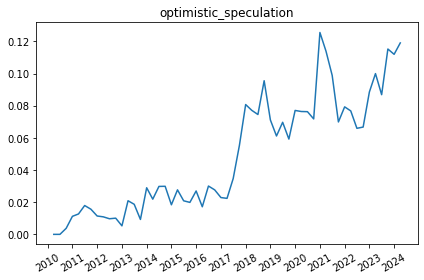

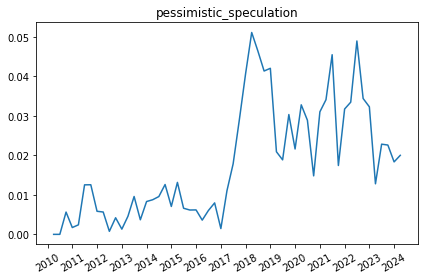

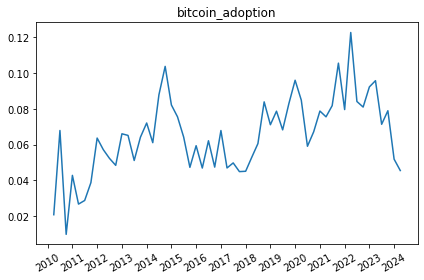

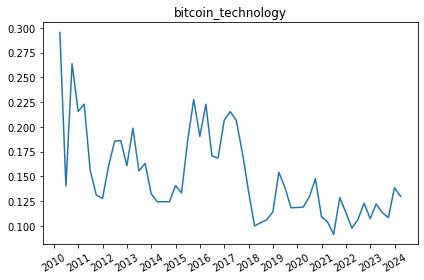

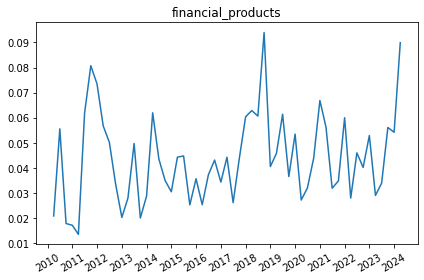

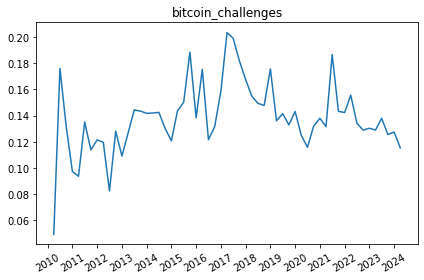

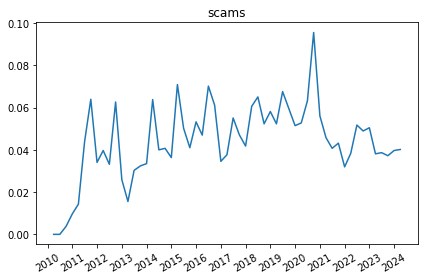

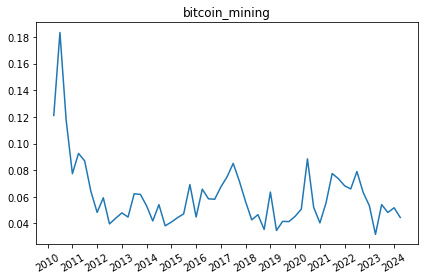

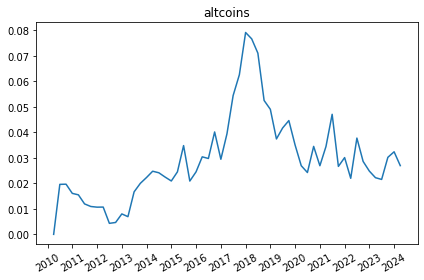

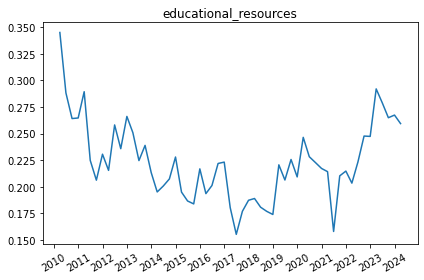

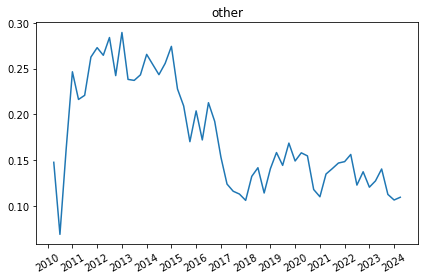

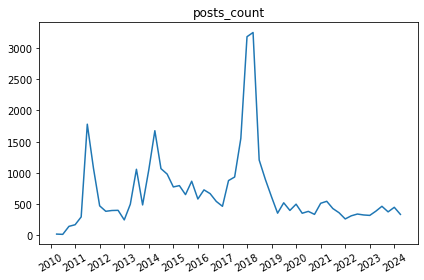

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

df = pd.read_csv('normalized_values.csv')
df["month"] = pd.to_datetime(df["month"])
df = df.set_index("month")

# convert to quarterly
df = df.resample('Q').mean()

# make a plot for each category
for category in categories+["posts_count"]:
    fig, ax = plt.subplots()
    ax.plot(df.index, df[category])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_title(category)
    plt.tight_layout()
    plt.savefig('pdfs/' + category + '.pdf', format='pdf')
    plt.show()